In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers import LeakyReLU  
from keras.layers import concatenate  
#from keras.models import Model  
from tensorflow.keras import Sequential,Model
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.utils import to_categorical  
#from keras.layers.advanced_activations import LeakyReLU  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  
import scipy.stats  
import datetime as dt  
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline 

In [2]:
df = pd.read_csv('camp4Final.csv')
df = df.drop(columns = ['AccountRef','TariffId'])
df = df.dropna()

In [3]:
df

,FuelTypeId,IsEconomy7,ElecConsumption,E7Consumption,GasConsumption,HasSwitched,Dno,TotalCost,TotalCostExclusive,Savings
0,2.0,0.0,4289.0,0.0,0.0,0.0,16.0,710.325210,725.205390,-14.880180
1,2.0,0.0,4644.0,0.0,0.0,1.0,16.0,764.621760,780.446940,-15.825180
2,2.0,0.0,4644.0,0.0,0.0,1.0,16.0,764.621760,780.446940,-15.825180
3,2.0,1.0,14163.0,10450.0,0.0,1.0,16.0,3441.057270,3674.728470,-233.671200
4,2.0,1.0,14163.0,10450.0,0.0,1.0,16.0,3441.057270,3674.728470,-233.671200
...,...,...,...,...,...,...,...,...,...,...
14167,3.0,0.0,8977.0,0.0,14059.0,0.0,15.0,1893.199392,1963.444046,-70.244653
14168,3.0,0.0,4086.0,0.0,27844.0,1.0,16.0,1641.419136,1604.860509,36.558627
14169,3.0,0.0,4086.0,0.0,27844.0,1.0,16.0,1641.419136,1604.860509,36.558627
14170,3.0,0.0,6099.0,0.0,10848.0,0.0,19.0,1414.699944,1471.289043,-56.589099


In [4]:
df['FuelTypeId'] = df['FuelTypeId'].astype(str) 
df['IsEconomy7'] = df['IsEconomy7'].astype(str) 
df['Dno'] = df['Dno'].astype(str) 
df.dtypes

FuelTypeId             object
IsEconomy7             object
ElecConsumption       float64
E7Consumption         float64
GasConsumption        float64
HasSwitched           float64
Dno                    object
TotalCost             float64
TotalCostExclusive    float64
Savings               float64
dtype: object

In [5]:
df_minority=df.loc[df['HasSwitched'] == 1]  
#Subsetting input features without target variable
df_minority_X=df_minority.loc[:, df_minority.columns != 'HasSwitched']
numerical_df = df_minority_X.select_dtypes("number")  
categorical_df = df_minority_X.select_dtypes("object")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)  
get_dummy_df = pd.get_dummies(categorical_df)    

In [6]:
#Seperating Each Category
FuelTypeId_dummy_col = [col for col in get_dummy_df.columns if 'FuelTypeId' in col]  
FuelTypeId_dummy = get_dummy_df[FuelTypeId_dummy_col]  
IsEconomy7_dummy_col = [col for col in get_dummy_df.columns if 'IsEconomy7' in col]  
IsEconomy7_dummy = get_dummy_df[IsEconomy7_dummy_col]  
Dno_dummy_col = [col for col in get_dummy_df.columns if 'Dno' in col]  
Dno_dummy = get_dummy_df[Dno_dummy_col] 

In [7]:
def GAN_generator(catdata1,catdata2,catdata3,numerical_data):    
  #Adding noise
    noise = Input(shape = (100,))    
    hidden_layer_1 = Dense(8, kernel_initializer = "he_uniform")(noise)  #approporiate weight initializer  
    hidden_layer_1 = LeakyReLU(0.2)(hidden_layer_1)# activation unit 
    hidden_layer_1 = BatchNormalization(momentum = 0.8)(hidden_layer_1)   # batch normalization is used across different layers to standardize the activations (zero mean and unit variance) from a prior layer and stabilize the training process 
    hidden_layer_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_layer_1)    
    hidden_layer_2 = LeakyReLU(0.2)(hidden_layer_2)    
    hidden_layer_2 = BatchNormalization(momentum = 0.8)(hidden_layer_2)    

    # Branch layer 1 for generating Fuel Type data

    branch_layer_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_layer_2)    
    branch_layer_1 = LeakyReLU(0.2)(branch_layer_1)    
    branch_layer_1 = BatchNormalization(momentum = 0.8)(branch_layer_1)    
    branch_layer_1 = Dense(64, kernel_initializer = "he_uniform")(branch_layer_1)    
    branch_layer_1 = LeakyReLU(0.2)(branch_layer_1)    
    branch_layer_1 = BatchNormalization(momentum=0.8)(branch_layer_1)
    branch_layer_1 = Dense(128, kernel_initializer = "he_uniform")(branch_layer_1)    
    branch_layer_1 = LeakyReLU(0.2)(branch_layer_1)    
    branch_layer_1 = BatchNormalization(momentum=0.8)(branch_layer_1)     
 
    #Output layer Layer1
    branch_layer_1_output = Dense(catdata1, activation = "softmax")(branch_layer_1)    

    #Branch layer 2 for generating Is Economy 7 data

    branch_layer_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_layer_2)    
    branch_layer_2 = LeakyReLU(0.2)(branch_layer_2)    
    branch_layer_2 = BatchNormalization(momentum = 0.8)(branch_layer_2)    
    branch_layer_2 = Dense(64, kernel_initializer = "he_uniform")(branch_layer_2)    
    branch_layer_2 = LeakyReLU(0.2)(branch_layer_2)    
    branch_layer_2 = BatchNormalization(momentum=0.8)(branch_layer_2)  
    branch_layer_2 = Dense(128, kernel_initializer = "he_uniform")(branch_layer_2)    
    branch_layer_2 = LeakyReLU(0.2)(branch_layer_2)    
    branch_layer_2 = BatchNormalization(momentum=0.8)(branch_layer_2) 

    #Output layer Layer2
    branch_layer_2_output = Dense(catdata2, activation = "softmax")(branch_layer_2) # softmax activation function is used for categorical variables

    #Branch layer 3 for generating DNO data

    branch_layer_3 = Dense(32, kernel_initializer = "he_uniform")(hidden_layer_2)    
    branch_layer_3 = LeakyReLU(0.2)(branch_layer_3)    
    branch_layer_3 = BatchNormalization(momentum = 0.8)(branch_layer_3)    
    branch_layer_3 = Dense(64, kernel_initializer = "he_uniform")(branch_layer_3)    
    branch_layer_3 = LeakyReLU(0.2)(branch_layer_3)    
    branch_layer_3 = BatchNormalization(momentum=0.8)(branch_layer_3) 
    branch_layer_3 = Dense(128, kernel_initializer = "he_uniform")(branch_layer_3)    
    branch_layer_3 = LeakyReLU(0.2)(branch_layer_3)    
    branch_layer_3 = BatchNormalization(momentum=0.8)(branch_layer_3)

    #Output Layer 3
    branch_layer_3_output = Dense(catdata3, activation = "softmax")(branch_layer_3) 
   
    #Branch layer 6 is used to produce numerical data 
    branch_layer_6 = Dense(64, kernel_initializer = "he_uniform")(hidden_layer_2)    
    branch_layer_6 = LeakyReLU(0.2)(branch_layer_6)    
    branch_layer_6 = BatchNormalization(momentum=0.8)(branch_layer_6)    
    branch_layer_6 = Dense(128, kernel_initializer = "he_uniform")(branch_layer_6)    
    branch_layer_6 = LeakyReLU(0.2)(branch_layer_6)    
    branch_layer_6 = BatchNormalization(momentum=0.8)(branch_layer_6)    
    branch_layer_6 = Dense(256, kernel_initializer = "he_uniform")(branch_layer_6)    
    branch_layer_6 = LeakyReLU(0.2)(branch_layer_6)    
    branch_layer_6 = BatchNormalization(momentum=0.8)(branch_layer_6)
    
    branch_layer_6_output = Dense(numerical_data, activation = "sigmoid")(branch_layer_6) #sigmoid is used for continuous variables.   

    #Combined layer output 
    #generator_output = concatenate([branch_layer_1_output, branch_layer_2_output, branch_layer_3_output,branch_layer_4_output,branch_layer_5_output,branch_layer_6_output])    
    combined_output = concatenate([branch_layer_1_output, branch_layer_2_output, branch_layer_3_output,branch_layer_6_output]) 

    #Return model 

    return Model(inputs = noise, outputs = combined_output)

    
generator = GAN_generator(FuelTypeId_dummy.shape[1],IsEconomy7_dummy.shape[1],Dno_dummy.shape[1],numerical_df_rescaled.shape[1])  
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            808         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8)            0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8)           32          ['leaky_re_lu[0][0]']            
 alization)                                                                                   

In [8]:
def GAN_discriminator(value_input):  
    #Input from generator
    dis_input = Input(shape = (value_input,))    
    n_layer = Dense(256, kernel_initializer="he_uniform")(dis_input)  
    n_layer = LeakyReLU(0.2)(n_layer) 
    n_layer = Dense(128, kernel_initializer="he_uniform")(n_layer)  
    n_layer = LeakyReLU(0.2)(n_layer)  
    n_layer = Dense(64, kernel_initializer="he_uniform")(n_layer)  
    n_layer = LeakyReLU(0.2)(n_layer)  
    n_layer = Dense(32, kernel_initializer="he_uniform")(n_layer)  
    n_layer = LeakyReLU(0.2)(n_layer)  
    n_layer = Dense(16, kernel_initializer="he_uniform")(n_layer)  
    n_layer = LeakyReLU(0.2)(n_layer)  
    n_layer = Dense(8, kernel_initializer="he_uniform")(n_layer)  
    n_layer = LeakyReLU(0.2)(n_layer)  

    #Output Layer
    n_layer_output = Dense(1, activation = "sigmoid")(n_layer)  # binary classification problem, so sigmoid activation is used in the output layer

    #compile and return model
    dis_model = Model(inputs = dis_input, outputs = n_layer_output)  
    dis_model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  # binary cross-entropy loss function is used in model compilation
    return dis_model  # Adam optimization algorithm with the learning rate LR of 0.0002 and the recommended beta1 momentum value of 0.5 is used.


value_input = FuelTypeId_dummy.shape[1]+IsEconomy7_dummy.shape[1]+Dno_dummy.shape[1]+numerical_df_rescaled.shape[1]
disc_GAN = GAN_discriminator(value_input)  
disc_GAN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense_18 (Dense)            (None, 256)               6144      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64)                0   

Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 4ms/step
Epoch: 2200 [Discriminator loss: 0.686592] [Generator loss: 0.764655]
32/32 [==============================] - 0s 3ms/step
Epoch: 2400 [Discriminator loss: 0.690418] [Generator loss: 0.765037]
32/32 [==============================] - 0s 3ms/step
Epoch: 2600 [Discriminator loss: 0.677105] [Generator loss: 0.752503]
32/32 [==============================] - 0s 3ms/step
Epoch: 2800 [Discriminator loss: 0.681062] [Generator loss: 0.758612]
32/32 [==============================] - 0s 3ms/step
Epoch: 3000 [Discriminator loss: 0.679368] [Generator loss: 0.755160]
32/32 [==============================] - 0s 3ms/step
Epoch: 3200 [Discriminator loss: 0.680309] [Generator loss: 0.752909]
32/32 [==============================] - 0s 6ms/step
Epoch: 3400 [Discriminator loss: 0.676162] [Generator loss: 0.746252]
32/32 [==============================] - 0s 4ms/step
Epoch: 3600 [Discriminator loss: 0.

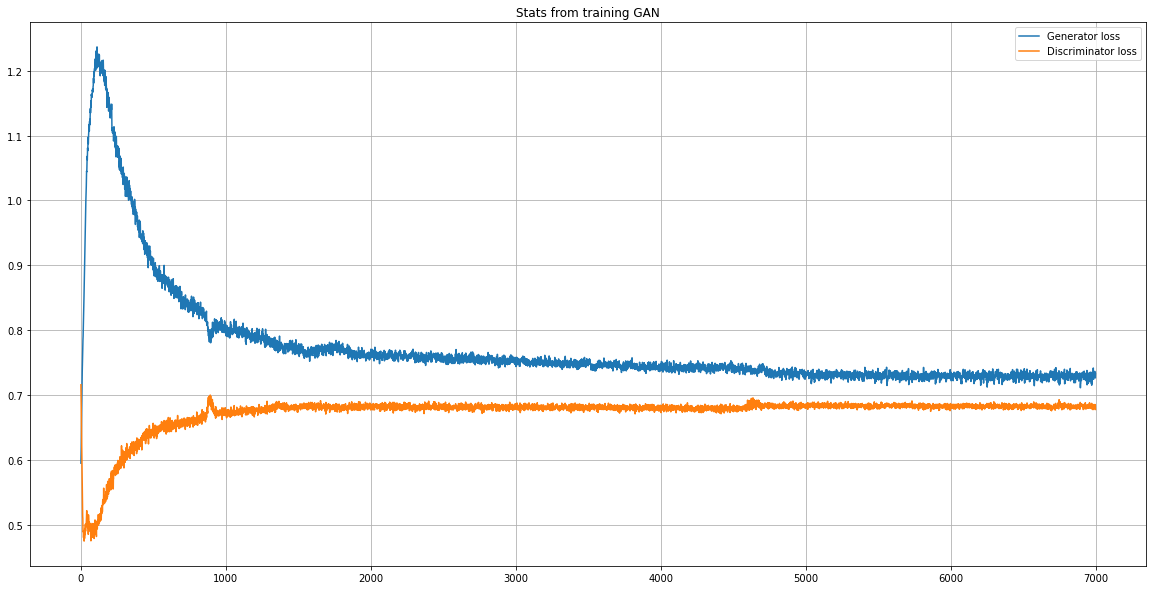

In [10]:
def Combined_Gan_Network(generator, disc_GAN):  #to complete the training generator and discriminator are passed. 
    disc_GAN.trainable = False  
    gan_output = disc_GAN(generator.output)  
    
    #Creating Gan Model
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model is being compiled.
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

GAN_network = Combined_Gan_Network(generator, disc_GAN)  

def Training_GAN(gan, generator, disc_GAN, catdata1,catdata2,catdata3,numerical, static_dim, n_epochs, n_batch, n_eval):  
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #Creating diffrent classes using numpy for fake and real data
    real = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    #for loop it iterate and train the network
    for i in range(n_epochs):  
        #Fetch Random parts of real data for discriminator
        idx = np.random.randint(0, catdata1.shape[0], half_batch)       
        Fueltype_real = catdata1[idx]  
        Iseconomy7_real = catdata2[idx]  
        Dno_real = catdata3[idx]            
        numerical_real = numerical_df_rescaled[idx]  

        #comlibining the data from above.
        real_data = np.concatenate([Fueltype_real, Iseconomy7_real,Dno_real,numerical_real], axis = 1)  
  
        #creating Fake noise to using random.normal
        noise = np.random.normal(0, 1, (half_batch, static_dim))  
        fake_data = generator.predict(noise)  
     
        #discriminator is trained
        d_loss_real, da_real = disc_GAN.train_on_batch(real_data, real)  
        d_loss_fake, da_fake = disc_GAN.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        #creating random noises in generator
        noise = np.random.normal(0, 1, (n_batch, static_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)  

        #check the performance of network
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()  

static_dim = 100  
Training_GAN(GAN_network, generator, disc_GAN, FuelTypeId_dummy.values,IsEconomy7_dummy.values,Dno_dummy.values,numerical_df_rescaled, static_dim, n_epochs = 7000, n_batch = 2037, n_eval = 200)



702/702 [==============================] - 2s 2ms/step
ElecConsumption compairing orignal and generated data


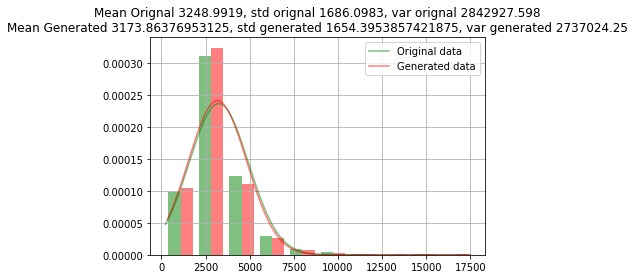

E7Consumption compairing orignal and generated data


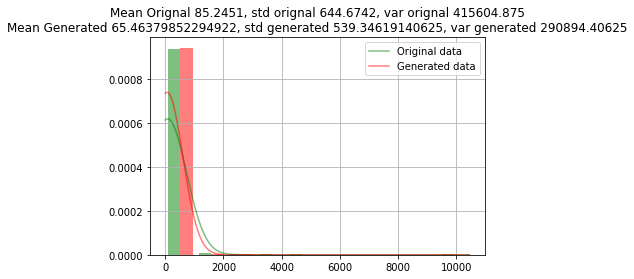

GasConsumption compairing orignal and generated data


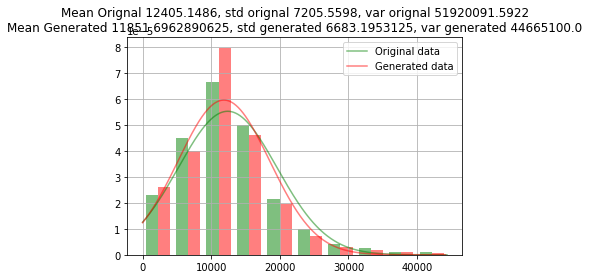

TotalCost compairing orignal and generated data


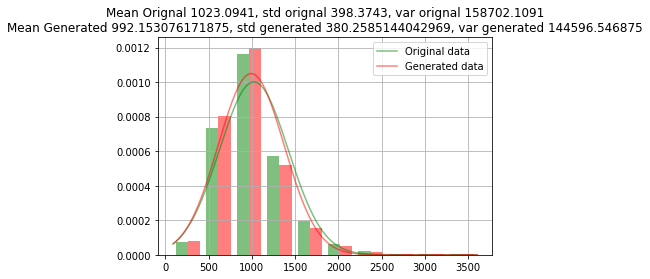

TotalCostExclusive compairing orignal and generated data


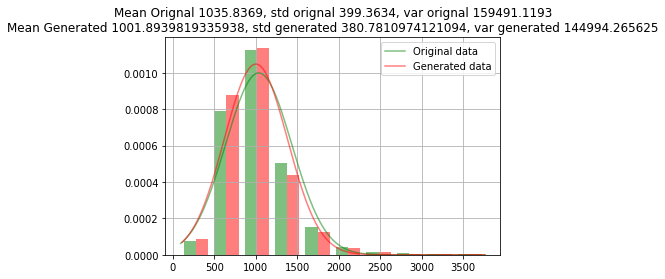

Savings compairing orignal and generated data


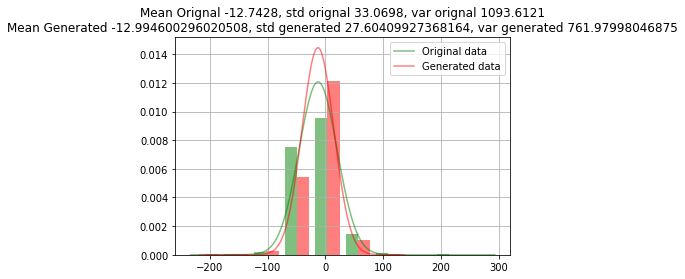

In [17]:
input_noise = np.random.normal(0, 1, (22443, 100)) # oversmapling is performed 22443 records of a minority class are added making the minority class 7963.  
GAN_Minority_oversample = generator.predict(input_noise)  
columns=list(FuelTypeId_dummy.columns)+list(IsEconomy7_dummy.columns)+list(Dno_dummy.columns)+list(numerical_df.columns)  
GAN_mixed_data = pd.DataFrame(data = GAN_Minority_oversample, columns = columns) 

GAN_mixed_data.iloc[:,:-6] = np.round(GAN_mixed_data.iloc[:,:-6])  
GAN_mixed_data.iloc[:,-6:] = scaling.inverse_transform(GAN_mixed_data.iloc[:,-6:])   

#Original Data
original_data = pd.concat([FuelTypeId_dummy,IsEconomy7_dummy,Dno_dummy,numerical_df], axis = 1)  
def distribution_plot(orignal, generated):  
    orignal_x = np.linspace(orignal.min(), orignal.max(), len(orignal))  
    generated_x = np.linspace(generated.min(), generated.max(), len(generated))  
    orignal_y = scipy.stats.norm.pdf(orignal_x, orignal.mean(), orignal.std())  
    generated_y = scipy.stats.norm.pdf(generated_x, generated.mean(), generated.std())  
    n, bins, patches = plt.hist([orignal, generated], density = True, alpha = 0.5, color = ["green", "red"])  
    xmin, xmax = plt.xlim()  
    plt.plot(orignal_x, orignal_y, color = "green", label = "Original data", alpha = 0.5)  
    plt.plot(generated_x, generated_y, color = "red", label = "Generated data", alpha = 0.5)  
    main_title = f"Mean Orignal {np.round(orignal.mean(), 4)}, std orignal {np.round(orignal.std(), 4)}, var orignal {np.round(orignal.var(), 4)}\nMean Generated {np.round(generated.mean(), 4)}, std generated {np.round(generated.std(), 4)}, var generated {np.round(generated.var(), 2)}"
    plt.title(main_title)  
    plt.legend()  
    plt.grid()  
    plt.show()  

Numeric_columns=numerical_df.columns  

for column in numerical_df.columns:  
    print(column, "compairing orignal and generated data")  
    distribution_plot(original_data[column], GAN_mixed_data[column])

,FuelTypeId_2.0,FuelTypeId_3.0,IsEconomy7_0.0,IsEconomy7_1.0,Dno_11.0,Dno_12.0,Dno_13.0,Dno_14.0,Dno_15.0,Dno_16.0,...,Dno_20.0,Dno_21.0,Dno_22.0,Dno_23.0,ElecConsumption,E7Consumption,GasConsumption,TotalCost,TotalCostExclusive,Savings
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,6329.426758,0.615033,36309.859375,2493.263672,2378.601318,48.846439
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1092.303345,0.190221,6634.288574,538.008118,642.739685,-32.943245
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3782.775635,0.171153,16349.395508,1219.158325,1211.718018,-1.696610
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3044.778076,840.705200,12387.876953,1283.467285,1218.694458,-13.122334
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2581.211670,817.635742,9948.461914,811.225098,882.005188,-25.617477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22438,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1589.038452,0.014200,8695.930664,675.354675,662.578186,-32.737267
22439,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5323.422363,0.600920,17199.134766,1497.676636,1504.994995,-21.082590
22440,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1492.966187,0.332663,8668.016602,676.732422,656.511292,-12.214335
22441,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1829.961060,0.001963,0.207577,230.641251,259.785828,-35.967472


In [18]:
GAN_mixed_data['ElecConsumption'] = GAN_mixed_data['ElecConsumption'].map('{:.2f}'.format) # we do not want any decimal places
GAN_mixed_data['E7Consumption'] = GAN_mixed_data['E7Consumption'].map('{:.2f}'.format)
GAN_mixed_data['GasConsumption'] = GAN_mixed_data['GasConsumption'].map('{:.2f}'.format)
GAN_mixed_data['TotalCost'] = GAN_mixed_data['TotalCost'].map('{:.2f}'.format) # we can have 2 decimal places
GAN_mixed_data['TotalCostExclusive'] = GAN_mixed_data['TotalCostExclusive'].map('{:.2f}'.format)
GAN_mixed_data['Savings'] = GAN_mixed_data['Savings'].map('{:.2f}'.format)

In [19]:
FuelTypeId_dummy,IsEconomy7_dummy,Dno_dummy,numerical_df

FuelTypeId_filter_col = [col for col in GAN_mixed_data if col.startswith('FuelTypeId')]  
FuelTypeId=GAN_mixed_data[FuelTypeId_filter_col]   
FuelTypeId= pd.get_dummies(FuelTypeId).idxmax(1)  
FuelTypeId= FuelTypeId.replace('FuelTypeId_', '', regex=True)  
GAN_Oversample = pd.DataFrame()   
GAN_Oversample['FuelTypeId']=FuelTypeId  

IsEconomy7_filter_col = [col for col in GAN_mixed_data if col.startswith('IsEconomy7')]  
IsEconomy7=GAN_mixed_data[IsEconomy7_filter_col]   
IsEconomy7= pd.get_dummies(IsEconomy7).idxmax(1)  
IsEconomy7= IsEconomy7.replace('IsEconomy7_', '', regex=True)  
GAN_Oversample['IsEconomy7']=IsEconomy7 

Dno_filter_col = [col for col in GAN_mixed_data if col.startswith('Dno')]  
Dno=GAN_mixed_data[Dno_filter_col]   
Dno= pd.get_dummies(Dno).idxmax(1)  
Dno= Dno.replace('Dno_', '', regex=True)  
GAN_Oversample['Dno']=Dno 

GAN_Oversample['HasSwitched']=1
GAN_Oversample[['ElecConsumption','E7Consumption','GasConsumption','TotalCost','TotalCostExclusive','Savings']]=GAN_mixed_data[['ElecConsumption','E7Consumption','GasConsumption','TotalCost','TotalCostExclusive','Savings']]

In [20]:
GAN_Oversample

,FuelTypeId,IsEconomy7,Dno,HasSwitched,ElecConsumption,E7Consumption,GasConsumption,TotalCost,TotalCostExclusive,Savings
0,3.0,0.0,17.0,1,2875.60,0.04,5698.09,722.49,694.81,-14.84
1,3.0,0.0,18.0,1,966.99,0.00,12858.98,736.86,685.04,22.97
2,3.0,0.0,16.0,1,2669.43,0.07,12596.54,862.15,927.64,-23.43
3,3.0,0.0,23.0,1,2350.76,0.10,10624.90,800.14,799.25,-5.66
4,3.0,0.0,14.0,1,3259.75,1.28,11695.39,973.55,995.99,-18.36
...,...,...,...,...,...,...,...,...,...,...
22438,3.0,0.0,23.0,1,5294.10,0.04,20792.27,1742.43,1572.15,35.23
22439,3.0,0.0,14.0,1,2982.30,0.79,10927.99,902.15,926.07,-26.74
22440,3.0,0.0,22.0,1,1763.12,0.01,8366.74,709.94,722.60,10.95
22441,3.0,0.0,15.0,1,2698.55,0.46,11433.45,945.27,938.15,-10.10


In [21]:
GAN_Oversample.nunique()

FuelTypeId                2
IsEconomy7                2
Dno                      12
HasSwitched               1
ElecConsumption       21821
E7Consumption          1694
GasConsumption        21619
TotalCost             20344
TotalCostExclusive    20270
Savings                8877
dtype: int64

In [22]:
df

,FuelTypeId,IsEconomy7,ElecConsumption,E7Consumption,GasConsumption,HasSwitched,Dno,TotalCost,TotalCostExclusive,Savings
0,2.0,0.0,4289.0,0.0,0.0,0.0,16.0,710.325210,725.205390,-14.880180
1,2.0,0.0,4644.0,0.0,0.0,1.0,16.0,764.621760,780.446940,-15.825180
2,2.0,0.0,4644.0,0.0,0.0,1.0,16.0,764.621760,780.446940,-15.825180
3,2.0,1.0,14163.0,10450.0,0.0,1.0,16.0,3441.057270,3674.728470,-233.671200
4,2.0,1.0,14163.0,10450.0,0.0,1.0,16.0,3441.057270,3674.728470,-233.671200
...,...,...,...,...,...,...,...,...,...,...
14167,3.0,0.0,8977.0,0.0,14059.0,0.0,15.0,1893.199392,1963.444046,-70.244653
14168,3.0,0.0,4086.0,0.0,27844.0,1.0,16.0,1641.419136,1604.860509,36.558627
14169,3.0,0.0,4086.0,0.0,27844.0,1.0,16.0,1641.419136,1604.860509,36.558627
14170,3.0,0.0,6099.0,0.0,10848.0,0.0,19.0,1414.699944,1471.289043,-56.589099


In [23]:
df1=df.append(GAN_Oversample, sort=False) 

In [24]:
df1['HasSwitched'].value_counts()

1.0    27624
0.0     8991
Name: HasSwitched, dtype: int64

In [25]:
df['HasSwitched'].value_counts()

0.0    8991
1.0    5181
Name: HasSwitched, dtype: int64